## Exercise to detect Algorithmically Generated Domain Names.
In this notebook we're going to use some great python modules to explore, understand and classify domains as being 'legit' or having a high probability of being generated by a DGA (Dynamic Generation Algorithm). We have 'legit' in quotes as we're using the domains in Alexa as the 'legit' set. The primary motivation is to explore the nexus of IPython, Pandas and scikit-learn with DGA classification as a vehicle for that exploration. The exercise intentionally shows common missteps, warts in the data, paths that didn't work out that well and results that could definitely be improved upon. In general capturing what worked and what didn't is not only more realistic but often much more informative. :)

### Python Modules Used:
- Pandas: Python Data Analysis Library (http://pandas.pydata.org)
- Scikit Learn (http://scikit-learn.org) Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
- Matplotlib:  Python 2D plotting library (http://matplotlib.org)

**Suggestions/Comments:**
Please send suggestions or bugs (I'm sure) to *clicklabs at clicksecurity.com*. Also if you have some datasets or would like to explore alternative approaches please touch base.



In [1]:
!! pip install matplotlib
!! pip install -U scikit-learn

['Requirement already satisfied: scikit-learn in /Users/ysrsnmz/opt/anaconda3/lib/python3.9/site-packages (1.1.1)',
 'Requirement already satisfied: numpy>=1.17.3 in /Users/ysrsnmz/opt/anaconda3/lib/python3.9/site-packages (from scikit-learn) (1.20.3)',
 'Requirement already satisfied: threadpoolctl>=2.0.0 in /Users/ysrsnmz/opt/anaconda3/lib/python3.9/site-packages (from scikit-learn) (2.2.0)',
 'Requirement already satisfied: joblib>=1.0.0 in /Users/ysrsnmz/opt/anaconda3/lib/python3.9/site-packages (from scikit-learn) (1.1.0)',
 'Requirement already satisfied: scipy>=1.3.2 in /Users/ysrsnmz/opt/anaconda3/lib/python3.9/site-packages (from scikit-learn) (1.7.1)']

In [2]:
import pylab
import numpy as np
import pandas as pd
import sklearn.feature_extraction
import json
import os
import copy
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Set default pylab stuff
pylab.rcParams['figure.figsize'] = (14.0, 5.0)
pylab.rcParams['axes.grid'] = True

In [4]:
# Version 0.12.0 of Pandas has a DeprecationWarning about Height blah that I'm ignoring
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
# This is the Alexa 100k domain list, we're not using the 1 Million just for speed reasons. Results
# for the Alexa 1M are given at the bottom of the notebook.
alexa_dataframe = pd.read_csv('data/alexa_100k.csv', names=['rank','uri'], header=None, encoding='utf-8')
alexa_dataframe.head(20)

,rank,uri
0,1,facebook.com
1,2,google.com
2,3,youtube.com
3,4,yahoo.com
4,5,baidu.com
5,6,wikipedia.org
6,7,amazon.com
7,8,live.com
8,9,qq.com
9,10,taobao.com


In [6]:
# Okay for this exercise we need the 2LD and nothing else
import tldextract

def domain_extract(uri):
    ext = tldextract.extract(uri)
    if (not ext.suffix):
        return np.nan
    else:
        return ext.domain

alexa_dataframe['domain'] = [ domain_extract(uri) for uri in alexa_dataframe['uri']]
del alexa_dataframe['rank']
del alexa_dataframe['uri']
alexa_dataframe.head()

,domain
0,facebook
1,google
2,youtube
3,yahoo
4,baidu


In [7]:
alexa_dataframe.tail()

,domain
99995,rhbabyandchild
99996,rm
99997,sat1
99998,nahimunkar
99999,musi


In [8]:
# It's possible we have NaNs from blanklines or whatever
alexa_dataframe = alexa_dataframe.dropna()
alexa_dataframe = alexa_dataframe.drop_duplicates()

# Set the class
alexa_dataframe['class'] = 'legit'

# Shuffle the data (important for training/testing)
alexa_dataframe = alexa_dataframe.reindex(np.random.permutation(alexa_dataframe.index))
alexa_total = alexa_dataframe.shape[0]
print ('Total Alexa domains %d' % alexa_total)

Total Alexa domains 91369


In [9]:
alexa_dataframe.head()

,domain,class
51054,ledaojia,legit
42722,brocabrac,legit
42865,applift,legit
47376,icemonkey,legit
29631,girlpower,legit


In [10]:
# Read in the DGA domains
dga_dataframe = pd.read_csv('data/dga_domains.txt', names=['raw_domain'], header=None, encoding='utf-8')

# We noticed that the blacklist values just differ by captilization or .com/.org/.info
dga_dataframe['domain'] = dga_dataframe.applymap(lambda x: x.split('.')[0].strip().lower())
del dga_dataframe['raw_domain']

# It's possible we have NaNs from blanklines or whatever
dga_dataframe = dga_dataframe.dropna()
dga_dataframe = dga_dataframe.drop_duplicates()
dga_total = dga_dataframe.shape[0]

# Set the class
dga_dataframe['class'] = 'dga'

print ('Total DGA domains %d' % dga_total)

Total DGA domains 2664


In [11]:
dga_dataframe.tail()

,domain,class
2664,xdbrbsbm,dga
2665,xdfjryydcfwvkvui,dga
2666,xdjlvcgw,dga
2667,xdrmjeu,dga
2668,xflrjyyjswoatsoq,dga


In [12]:
# Concatenate the domains in a big pile!
all_domains = pd.concat([alexa_dataframe, dga_dataframe], ignore_index=True)

In [13]:
# Add a length field for the domain
all_domains['length'] = [len(x) for x in all_domains['domain']]

# Okay since we're trying to detect dynamically generated domains and short
# domains (length <=6) are crazy random even for 'legit' domains we're going
# to punt on short domains (perhaps just white/black list for short domains?)
all_domains = all_domains[all_domains['length'] > 6]

In [14]:
# Grabbed this from Rosetta Code (rosettacode.org)
import math
from collections import Counter
 
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())

In [15]:
# Add a entropy field for the domain
all_domains['entropy'] = [entropy(x) for x in all_domains['domain']]

In [16]:
all_domains.head()

,domain,class,length,entropy
0,ledaojia,legit,8,2.750000
1,brocabrac,legit,9,2.281036
2,applift,legit,7,2.521641
3,icemonkey,legit,9,2.947703
4,girlpower,legit,9,2.947703


In [17]:
all_domains.tail()

,domain,class,length,entropy
94028,xdbrbsbm,dga,8,2.405639
94029,xdfjryydcfwvkvui,dga,16,3.500000
94030,xdjlvcgw,dga,8,3.000000
94031,xdrmjeu,dga,7,2.807355
94032,xflrjyyjswoatsoq,dga,16,3.500000


## Lets plot some stuff!

Text(0, 0.5, 'Domain Entropy')

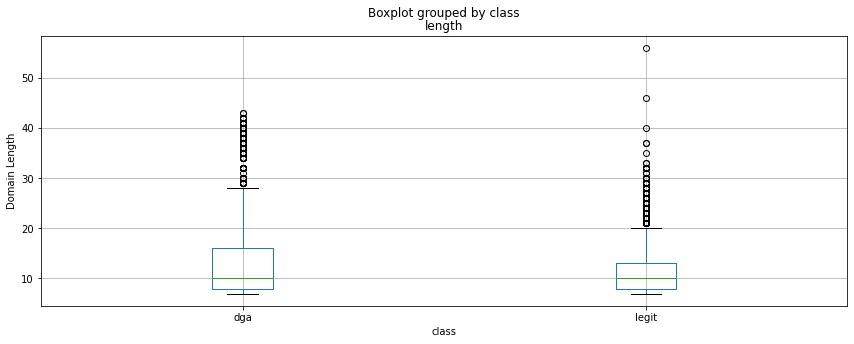

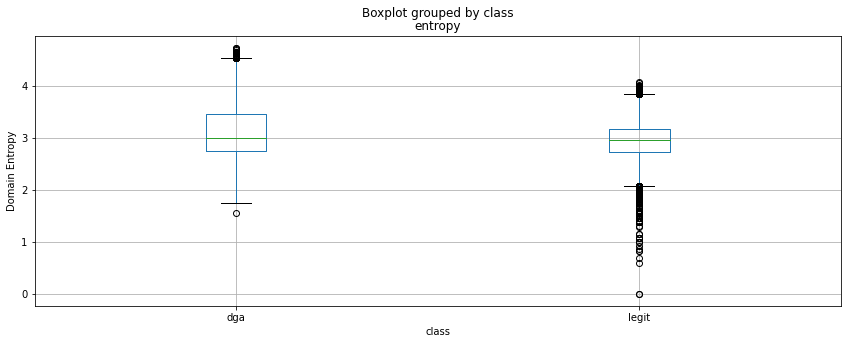

In [18]:
# Boxplots show you the distribution of the data (spread).
# http://en.wikipedia.org/wiki/Box_plot

# Plot the length and entropy of domains
all_domains.boxplot('length','class')
pylab.ylabel('Domain Length')
all_domains.boxplot('entropy','class')
pylab.ylabel('Domain Entropy')

Text(0, 0.5, 'Domain Entropy')

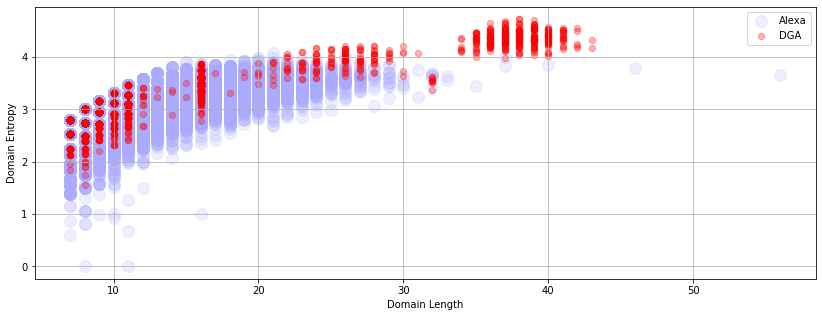

In [19]:
# Split the classes up so we can set colors, size, labels
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
alexa = all_domains[~cond]
plt.scatter(alexa['length'], alexa['entropy'], s=140, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['length'], dga['entropy'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Domain Entropy')

# Below you can see that our DGA domains do tend to have higher entropy than Alexa on average.

In [20]:
# Lets look at the types of domains that have entropy higher than 4
high_entropy_domains = all_domains[all_domains['entropy'] > 4]
print ('Num Domains above 4 entropy: %.2f%% %d (out of %d)' % \
            (100.0*high_entropy_domains.shape[0]/all_domains.shape[0],high_entropy_domains.shape[0],all_domains.shape[0]))
print ("Num high entropy legit: %d" % high_entropy_domains[high_entropy_domains['class']=='legit'].shape[0])
print ("Num high entropy DGA: %d" % high_entropy_domains[high_entropy_domains['class']=='dga'].shape[0])
high_entropy_domains[high_entropy_domains['class']=='legit'].head()

# Looking at the results below, we do see that there are more domains
# in the DGA group that are high entropy but only a small percentage
# of the domains are in that high entropy range...

Num Domains above 4 entropy: 0.52% 366 (out of 69972)
Num high entropy legit: 3
Num high entropy DGA: 363


,domain,class,length,entropy
50819,burzhunetdlyachaynikov,legit,22,4.004886
54524,congresomundialjjrperu2009,legit,26,4.056021
73282,theukwebdesigncompany,legit,21,4.070656


In [21]:
high_entropy_domains[high_entropy_domains['class']=='dga'].head()

,domain,class,length,entropy
91387,a17btkyb38gxe41pwd50nxmzjxiwjwdwfrp52,dga,37,4.540402
91388,a17c49l68ntkqnuhvkrmyb28fubvn30e31g43dq,dga,39,4.631305
91389,a17d60gtnxk47gskti15izhvlviyksh64nqkz,dga,37,4.270132
91390,a17erpzfzh64c69csi35bqgvp52drita67jzmy,dga,38,4.629249
91391,a17fro51oyk67b18ksfzoti55j36p32o11fvc29cr,dga,41,4.305859


In [119]:
# In preparation for using scikit learn we're just going to use
# some handles that help take us from pandas land to scikit land

# List of feature vectors (scikit learn uses 'X' for the matrix of feature vectors)
#X = np.array(all_domains.values(['length', 'entropy']))

# Labels (scikit learn uses 'y' for classification labels)
y1 = np.asarray(all_domains['class'].tolist()) # Yes, this is weird but it needs 
                                            # to be an np.array of strings
y = y1.reshape(-1,1)    

xdata = all_domains['length']
ydata = all_domains['entropy']
zdata = all_domains['class']
zdata2 = zdata.tolist()

X1 = np.array(xdata, ydata)
X = X1.reshape(-1,1)
print(X)


print(y)

[[ 8.]
 [ 9.]
 [ 7.]
 ...
 [ 8.]
 [ 7.]
 [16.]]
[['legit']
 ['legit']
 ['legit']
 ...
 ['dga']
 ['dga']
 ['dga']]


In [120]:
# Random Forest is a popular ensemble machine learning classifier.
# http://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#
import sklearn.ensemble
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=20) # Trees in the forest

In [121]:
# Now we can use scikit learn's cross validation to assess predictive performance.
from sklearn.model_selection import cross_val_score, cross_validate
scores = sklearn.model_selection.cross_val_score(clf, X, y, cv=5, n_jobs=4)
print(scores)

/Users/ysrsnmz/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ysrsnmz/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ysrsnmz/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ysrsnmz/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_valida

[0.96720257 0.96570204 0.96727169 0.96398456 0.96048306]


In [123]:
# Wow 96% accurate! At this point we could claim success and we'd be gigantic morons...
# Recall that we have ~100k 'legit' domains and only 3.5k DGA domains
# So a classifier that marked everything as legit would be about
# 96% accurate....

# So we dive in a bit and look at the predictive performance more deeply.

# Train on a 80/20 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

/var/folders/f_/hg_pbkg51kng9_bd7_fdzjdh0000gn/T/ipykernel_67070/1198035307.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Confusion Matrix Stats
legit/legit: 13.97% (75/537)
legit/dga: 86.03% (462/537)
dga/legit: 0.07% (10/13448)
dga/dga: 99.93% (13438/13448)


/var/folders/f_/hg_pbkg51kng9_bd7_fdzjdh0000gn/T/ipykernel_67070/2640332528.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/var/folders/f_/hg_pbkg51kng9_bd7_fdzjdh0000gn/T/ipykernel_67070/2640332528.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


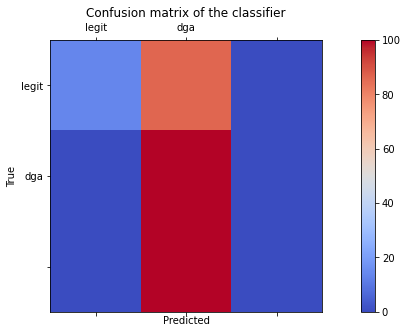

In [125]:
# Now plot the results of the 80/20 split in a confusion matrix
from sklearn.metrics import confusion_matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred)

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    
    print ('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print ("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Show confusion matrix
    # Thanks kermit666 from stackoverflow :)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='coolwarm')
    pylab.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    pylab.xlabel('Predicted')
    pylab.ylabel('True')
    pylab.show()

plot_cm(cm, labels)

# We can see below that our suspicions were correct and the classifier is
# marking almost everything as Alexa. We FAIL.. science is hard... lets go drinking....

In [126]:
# Well our Mom told us we were still cool.. so with that encouragement we're
# going to compute NGrams for every Alexa domain and see if we can use the
# NGrams to help us better differentiate and mark DGA domains...

# Scikit learn has a nice NGram generator that can generate either char NGrams or word NGrams (we're using char).
# Parameters: 
#       - ngram_range=(3,5)  # Give me all ngrams of length 3, 4, and 5
#       - min_df=1e-4        # Minimumum document frequency. At 1e-4 we're saying give us NGrams that 
#                            # happen in at least .1% of the domains (so for 100k... at least 100 domains)
alexa_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-4, max_df=1.0)

In [127]:
# I'm SURE there's a better way to store all the counts but not sure...
# At least the min_df parameters has already done some thresholding
counts_matrix = alexa_vc.fit_transform(alexa_dataframe['domain'])
alexa_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = alexa_vc.get_feature_names_out()

In [128]:
# For fun sort it and show it
import operator
_sorted_ngrams = sorted(zip(ngrams_list, alexa_counts), key=operator.itemgetter(1), reverse=True)
print ('Alexa NGrams: %d' % len(_sorted_ngrams))
for ngram, count in _sorted_ngrams[:10]:
    print (ngram, count)

Alexa NGrams: 23613
ing 3.443888546777372
lin 3.4271614029259654
ine 3.399673721481038
tor 3.26528962586083
ter 3.2631624649622166
ion 3.246252312299322
ent 3.228913405994688
por 3.2013971243204513
the 3.2005769267548483
ree 3.16345955176999


In [130]:
# We're also going to throw in a bunch of dictionary words
word_dataframe = pd.read_csv('data/words.txt', names=['word'], header=None, dtype={'word': np.str}, encoding='utf-8')

# Cleanup words from dictionary
word_dataframe = word_dataframe[word_dataframe['word'].map(lambda x: str(x).isalpha())]
word_dataframe = word_dataframe.applymap(lambda x: str(x).strip().lower())
word_dataframe = word_dataframe.dropna()
word_dataframe = word_dataframe.drop_duplicates()
word_dataframe.head(10)

,word
37,a
48,aa
51,aaa
53,aaaa
54,aaaaaa
55,aaal
56,aaas
57,aaberg
58,aachen
59,aae


In [131]:
# Now compute NGrams on the dictionary words
# Same logic as above...
dict_vc = sklearn.feature_extraction.text.CountVectorizer(analyzer='char', ngram_range=(3,5), min_df=1e-5, max_df=1.0)
counts_matrix = dict_vc.fit_transform(word_dataframe['word'])
dict_counts = np.log10(counts_matrix.sum(axis=0).getA1())
ngrams_list = dict_vc.get_feature_names_out()

In [132]:
# For fun sort it and show it
import operator
_sorted_ngrams = sorted(zip(ngrams_list, dict_counts), key=operator.itemgetter(1), reverse=True)
print ('Word NGrams: %d' % len(_sorted_ngrams))
for ngram, count in _sorted_ngrams[:10]:
    print (ngram, count)

Word NGrams: 123061
ing 4.387300822448285
ess 4.204879333760662
ati 4.1933472563864616
ion 4.165036479994566
ter 4.162415036106447
nes 4.112504458767161
tio 4.076822423342773
ate 4.0723602039634885
ent 4.069631102620343
tion 4.0496056125949735


In [133]:
# We use the transform method of the CountVectorizer to form a vector
# of ngrams contained in the domain, that vector is than multiplied
# by the counts vector (which is a column sum of the count matrix).
def ngram_count(domain):
    alexa_match = alexa_counts * alexa_vc.transform([domain]).T  # Woot vector multiply and transpose Woo Hoo!
    dict_match = dict_counts * dict_vc.transform([domain]).T
    print ('%s Alexa match:%d Dict match: %d' % (domain, alexa_match, dict_match))

# Examples:
ngram_count('google')
ngram_count('facebook')
ngram_count('1cb8a5f36f')
ngram_count('pterodactylfarts')
ngram_count('ptes9dro-dwacty2lfa5rrts')
ngram_count('beyonce')
ngram_count('bey666on4ce')

google Alexa match:17 Dict match: 14
facebook Alexa match:31 Dict match: 27
1cb8a5f36f Alexa match:0 Dict match: 0
pterodactylfarts Alexa match:35 Dict match: 76
ptes9dro-dwacty2lfa5rrts Alexa match:19 Dict match: 28
beyonce Alexa match:15 Dict match: 16
bey666on4ce Alexa match:2 Dict match: 1


In [134]:
# Compute NGram matches for all the domains and add to our dataframe
all_domains['alexa_grams']= alexa_counts * alexa_vc.transform(all_domains['domain']).T 
all_domains['word_grams']= dict_counts * dict_vc.transform(all_domains['domain']).T 
all_domains.head()

,domain,class,length,entropy,alexa_grams,word_grams,diff
0,ledaojia,legit,8,2.750000,14.606802,10.687746,3.919056
1,brocabrac,legit,9,2.281036,17.389280,36.827434,-19.438154
2,applift,legit,7,2.521641,17.145587,25.821467,-8.675879
3,icemonkey,legit,9,2.947703,26.081392,34.711051,-8.629660
4,girlpower,legit,9,2.947703,21.710475,24.105366,-2.394891


In [135]:
all_domains.tail()

,domain,class,length,entropy,alexa_grams,word_grams,diff
94028,xdbrbsbm,dga,8,2.405639,2.392697,4.293495,-1.900798
94029,xdfjryydcfwvkvui,dga,16,3.500000,1.000000,0.698970,0.301030
94030,xdjlvcgw,dga,8,3.000000,0.000000,0.000000,0.000000
94031,xdrmjeu,dga,7,2.807355,1.643453,1.000000,0.643453
94032,xflrjyyjswoatsoq,dga,16,3.500000,8.879714,15.218889,-6.339174


In [136]:
# Use the vectorized operations of the dataframe to investigate differences
# between the alexa and word grams
all_domains['diff'] = all_domains['alexa_grams'] - all_domains['word_grams']
all_domains.sort_values(['diff'], ascending=True).head(10)

# The table below shows those domain names that are more 'dictionary' and less 'web'

,domain,class,length,entropy,alexa_grams,word_grams,diff
2698,bipolardisorderdepressionanxiety,legit,32,3.616729,117.315717,190.833856,-73.518139
64356,channel4embarrassingillnesses,legit,29,3.440070,95.793524,169.119440,-73.325916
45248,stirringtroubleinternationally,legit,30,3.481728,134.047993,207.204729,-73.156736
54020,americansforresponsiblesolutions,legit,32,3.667838,148.142007,218.363956,-70.221949
64134,pragmatismopolitico,legit,19,3.326360,61.244630,121.536223,-60.291593
17223,egaliteetreconciliation,legit,23,3.186393,91.936742,152.125325,-60.188583
45399,interoperabilitybridges,legit,23,3.588354,95.037285,153.626312,-58.589028
54163,foreclosurephilippines,legit,22,3.447402,74.506548,132.514638,-58.008090
88978,annamalicesissyselfhypnosis,legit,27,3.429908,68.680068,126.667692,-57.987623
57354,corazonindomablecapitulos,legit,25,3.813661,75.529451,133.160690,-57.631240


In [137]:
all_domains.sort_values(['diff'], ascending=False).head(50)

# The table below shows those domain names that are more 'web' and less 'dictionary'
# Good O' web....

,domain,class,length,entropy,alexa_grams,word_grams,diff
35593,gay-sex-pics-porn-pictures-gay-sex-porn-gay-se...,legit,56,3.661056,159.642633,85.124184,74.518449
89492,article-directory-free-submission-free-content,legit,46,3.786816,235.229615,188.230453,46.999163
64033,stream-free-movies-online,legit,25,3.509275,120.250616,74.496915,45.753701
47073,watch-free-movie-online,legit,23,3.708132,103.029245,58.943451,44.085794
44036,best-online-shopping-site,legit,25,3.452879,123.376840,79.596640,43.780200
64057,social-bookmarking-sites-list,legit,29,3.702472,145.754865,102.261826,43.493039
64447,free-online-directory,legit,21,3.403989,123.379411,80.735030,42.644380
53002,free-links-articles-directory,legit,29,3.702472,153.238728,110.955361,42.283366
53022,online-web-directory,legit,20,3.584184,116.310390,74.082948,42.227442
86074,web-directory-online,legit,20,3.584184,114.402344,74.082948,40.319395


Text(0, 0.5, 'Alexa NGram Matches')

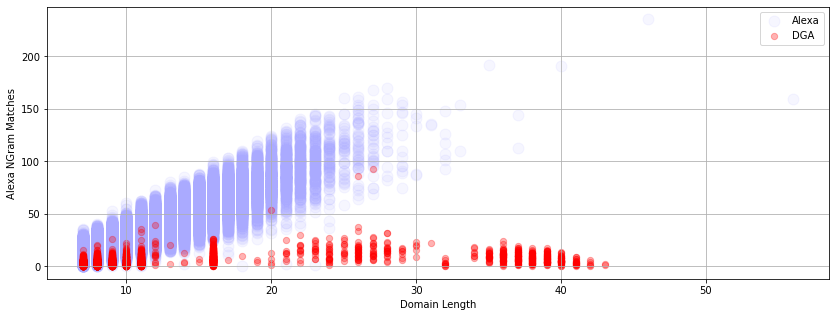

In [138]:
# Lets plot some stuff!
# Here we want to see whether our new 'alexa_grams' feature can help us differentiate between Legit/DGA
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['length'], legit['alexa_grams'], s=120, c='#aaaaff', label='Alexa', alpha=.1)
plt.scatter(dga['length'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Alexa NGram Matches')

Text(0, 0.5, 'Alexa Gram Matches')

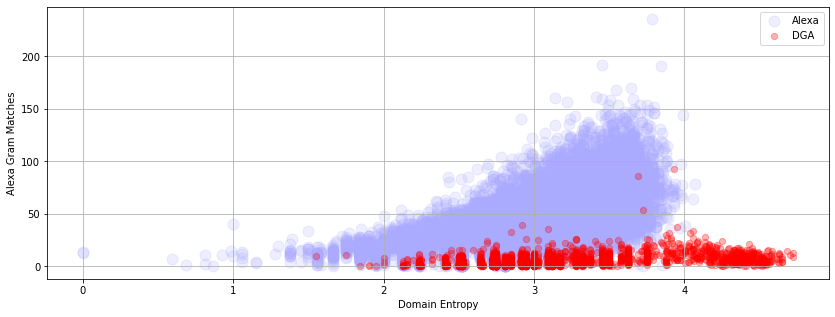

In [139]:
# Lets plot some stuff!
# Here we want to see whether our new 'alexa_grams' feature can help us differentiate between Legit/DGA
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['entropy'], legit['alexa_grams'],  s=120, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['entropy'], dga['alexa_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Domain Entropy')
pylab.ylabel('Alexa Gram Matches')

Text(0, 0.5, 'Dictionary NGram Matches')

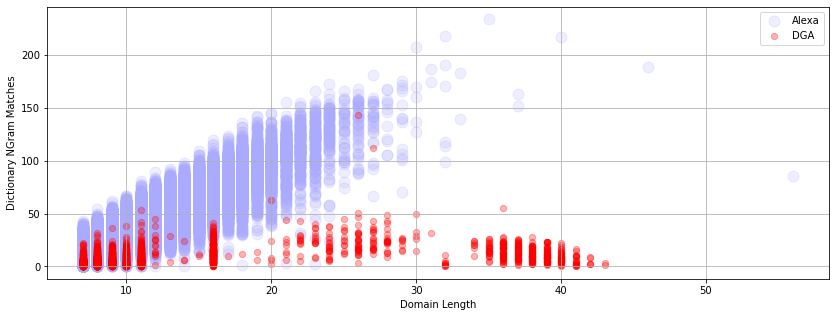

In [140]:
# Lets plot some stuff!
# Here we want to see whether our new 'word_grams' feature can help us differentiate between Legit/DGA
# Note: It doesn't look quite as good as the Alexa_grams but it might generalize better (less overfit).
cond = all_domains['class'] == 'dga'
dga = all_domains[cond]
legit = all_domains[~cond]
plt.scatter(legit['length'], legit['word_grams'],  s=120, c='#aaaaff', label='Alexa', alpha=.2)
plt.scatter(dga['length'], dga['word_grams'], s=40, c='r', label='DGA', alpha=.3)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Dictionary NGram Matches')

In [141]:
# Lets look at which Legit domains are scoring low on the word gram count
all_domains[(all_domains['word_grams']==0)].head()

,domain,class,length,entropy,alexa_grams,word_grams,diff
185,tv-in-pc,legit,8,2.750000,7.917537,0.0,7.917537
739,0594111,legit,7,2.128085,3.892762,0.0,3.892762
3012,fzzfgjj,weird,7,1.950212,1.000000,0.0,1.000000
4827,as42926,weird,7,2.521641,0.000000,0.0,0.000000
4928,cpjc365,legit,7,2.521641,2.086360,0.0,2.086360


In [142]:
# Okay these look kinda weird, lets use some nice Pandas functionality
# to look at some statistics around our new features.
all_domains[all_domains['class']=='legit'].describe()

,length,entropy,alexa_grams,word_grams,diff
count,67217.000000,67217.000000,67217.000000,67217.000000,67217.000000
mean,10.871238,2.930705,33.441999,40.776501,-7.334502
std,3.384887,0.345857,19.474903,23.206095,9.345440
min,7.000000,-0.000000,0.000000,0.000000,-73.518139
25%,8.000000,2.725481,19.273842,23.975270,-12.466487
50%,10.000000,2.947703,29.007611,36.153030,-6.706433
75%,13.000000,3.169925,42.870105,52.893630,-1.617526
max,56.000000,4.070656,235.229615,233.648571,74.518449


Text(0, 0.5, 'Maximum NGram Score')

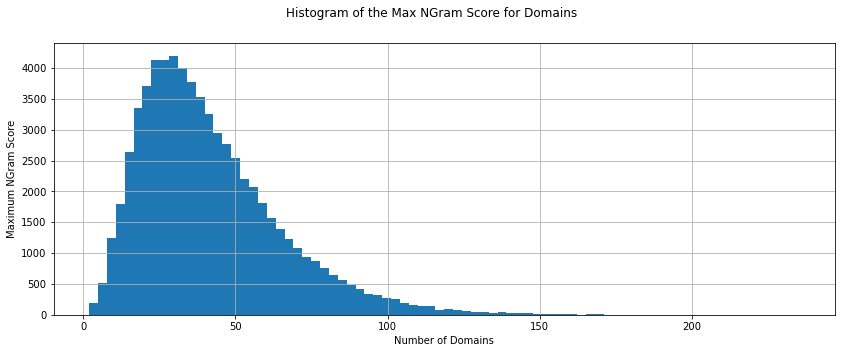

In [145]:
# Lets look at how many domains that are both low in word_grams and alexa_grams (just plotting the max of either)
legit = all_domains[(all_domains['class']=='legit')]
max_grams = np.maximum(legit['alexa_grams'],legit['word_grams'])
ax = max_grams.hist(bins=80)
ax.figure.suptitle('Histogram of the Max NGram Score for Domains')
pylab.xlabel('Number of Domains')
pylab.ylabel('Maximum NGram Score')

In [150]:
# Lets look at which Legit domains are scoring low on both alexa and word gram count
weird_cond = (all_domains['class']=='legit') & (all_domains['word_grams']<3) & (all_domains['alexa_grams']<2)
weird = all_domains[weird_cond]
print (weird.shape[0])
weird.head(30)

0


,domain,class,length,entropy,alexa_grams,word_grams,diff


In [151]:
# Epiphany... Alexa really may not be the best 'exemplar' set...  
#             (probably a no-shit moment for everyone else :)
#
# Discussion: If you're using these as exemplars of NOT DGA, then your probably
#             making things very hard on your machine learning algorithm.
#             Perhaps we should have two categories of Alexa domains, 'legit'
#             and a 'weird'. based on some definition of weird.
#             Looking at the entries above... we have approx 80 domains
#             that we're going to mark as 'weird'.
#
all_domains.loc[weird_cond, 'class'] = 'weird'
print (all_domains['class'].value_counts())
all_domains[all_domains['class'] == 'weird'].head()

legit    67217
dga       2664
weird       91
Name: class, dtype: int64


,domain,class,length,entropy,alexa_grams,word_grams,diff
224,bjltwybj,weird,8,2.500000,0.000000,2.167317,-2.167317
806,xn--42cgk1gc8crdb1htg3d,weird,23,3.849224,1.342423,2.411620,-1.069197
3012,fzzfgjj,weird,7,1.950212,1.000000,0.000000,1.000000
3510,mmmppp333,weird,9,1.584963,1.414973,1.982271,-0.567298
4604,xn--12clb9joa5dc2o,weird,18,3.725481,0.000000,1.397940,-1.397940


In [188]:
# Now we try our machine learning algorithm again with the new features
# Alexa and Dictionary NGrams and the exclusion of the bad exemplars.
#X = all_domains.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])

# Labels (scikit learn uses 'y' for classification labels)
#y = np.array(all_domains['class'].tolist())

# Train on a 80/20 split
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)




y1 = np.asarray(all_domains['class'].tolist())
                                           
y = y1.reshape(-1,1)    

xdata = all_domains['length']
ydata = all_domains['entropy']
xdata1 = all_domains['alexa_grams']
xdata2 = all_domains['word_grams']

zdata = all_domains['class']
zdata2 = zdata.tolist()

X1 = [xdata, ydata, xdata1, xdata2]
X2 = np.array(X1)
X = X2.reshape(-1,1)
print(X)


print(y)

# Train on a 80/20 split
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)



[[14.60680152]
 [17.38927961]
 [17.1455873 ]
 ...
 [ 0.        ]
 [ 1.        ]
 [15.21888879]]
[['legit']
 ['legit']
 ['legit']
 ...
 ['dga']
 ['dga']
 ['dga']]


ValueError: Found input variables with inconsistent numbers of samples: [139944, 69972]

Confusion Matrix Stats
legit/legit: 13.97% (75/537)
legit/weird: 86.03% (462/537)
legit/dga: 0.00% (0/537)
weird/legit: 0.07% (10/13448)
weird/weird: 99.93% (13438/13448)
weird/dga: 0.00% (0/13448)
dga/legit: 0.00% (0/10)
dga/weird: 100.00% (10/10)
dga/dga: 0.00% (0/10)


/var/folders/f_/hg_pbkg51kng9_bd7_fdzjdh0000gn/T/ipykernel_67070/2640332528.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/var/folders/f_/hg_pbkg51kng9_bd7_fdzjdh0000gn/T/ipykernel_67070/2640332528.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


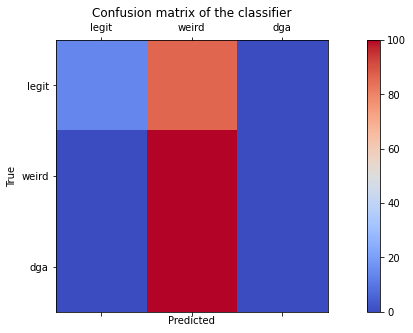

In [163]:
# Now plot the results of the 80/20 split in a confusion matrix
labels = ['legit', 'weird', 'dga']
cm = confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)

In [164]:
# Hun, well that seem to work 'ok', but you don't really want a classifier
# that outputs 3 classes, you'd like a classifier that flags domains as DGA or not.
# This was a path that seemed like a good idea until it wasn't....

In [178]:
# Perhaps we will just exclude the weird class from our ML training
not_weird = all_domains[all_domains['class'] != 'weird']
X = np.array(['length', 'entropy', 'alexa_grams', 'word_grams'])

# Labels (scikit learn uses 'y' for classification labels)
y = np.array(not_weird['class'].tolist())

# Train on a 80/20 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [4, 69881]

Confusion Matrix Stats
legit/legit: 13.97% (75/537)
legit/dga: 86.03% (462/537)
dga/legit: 0.07% (10/13448)
dga/dga: 99.93% (13438/13448)


/var/folders/f_/hg_pbkg51kng9_bd7_fdzjdh0000gn/T/ipykernel_67070/2640332528.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
/var/folders/f_/hg_pbkg51kng9_bd7_fdzjdh0000gn/T/ipykernel_67070/2640332528.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


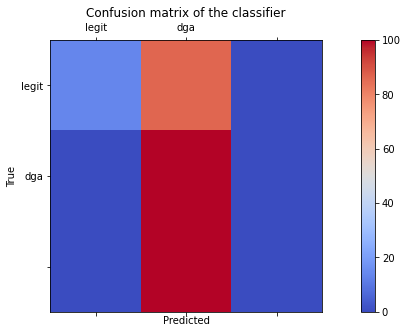

In [180]:
# Now plot the results of the 80/20 split in a confusion matrix
labels = ['legit', 'dga']
cm = confusion_matrix(y_test, y_pred)
plot_cm(cm, labels) 

In [181]:
# Well it's definitely better.. but haven't we just cheated by removing
# the weird domains?  Well perhaps, but on some level we're removing
# outliers that are bad exemplars. So to validate that the model is still
# doing the right thing lets try our new model prediction on our hold out sets.

# First train on the whole thing before looking at prediction performance
clf.fit(X, y)

# Pull together our hold out set
hold_out_domains = pd.concat([hold_out_alexa, hold_out_dga], ignore_index=True)

# Add a length field for the domain
hold_out_domains['length'] = [len(x) for x in hold_out_domains['domain']]
hold_out_domains = hold_out_domains[hold_out_domains['length'] > 6]

# Add a entropy field for the domain
hold_out_domains['entropy'] = [entropy(x) for x in hold_out_domains['domain']]

# Compute NGram matches for all the domains and add to our dataframe
hold_out_domains['alexa_grams']= alexa_counts * alexa_vc.transform(hold_out_domains['domain']).T
hold_out_domains['word_grams']= dict_counts * dict_vc.transform(hold_out_domains['domain']).T

hold_out_domains.head()

ValueError: could not convert string to float: 'length'

In [182]:
# List of feature vectors (scikit learn uses 'X' for the matrix of feature vectors)
hold_X = hold_out_domains.as_matrix(['length', 'entropy', 'alexa_grams', 'word_grams'])

# Labels (scikit learn uses 'y' for classification labels)
hold_y = np.array(hold_out_domains['class'].tolist())

# Now run through the predictive model
hold_y_pred = clf.predict(hold_X)

# Add the prediction array to the dataframe
hold_out_domains['pred'] = hold_y_pred

# Now plot the results
labels = ['legit', 'dga']
cm = confusion_matrix(hold_y, hold_y_pred, labels)
plot_cm(cm, labels) 

NameError: name 'hold_out_domains' is not defined

In [ ]:
# Okay so on our 10% hold out set of 10k domains about ~100 domains were mis-classified
# at this point we're made some good progress so we're going to claim success :)
#       - Out of 10k domains 100 were mismarked
#       - false positives (Alexa marked as DGA) = ~0.6%
#       - about 80% of the DGA are getting marked

# Note: Alexa 1M results on the 10% hold out (100k domains) were in the same ballpark 
#       - Out of 100k domains 432 were mismarked
#       - false positives (Alexa marked as DGA) = 0.4%
#       - about 70% of the DGA are getting marked

# Now were going to just do some post analysis on how the ML algorithm performed.

# Lets look at a couple of plots to see which domains were misclassified.
# Looking at Length vs. Alexa NGrams
fp_cond = ((hold_out_domains['class'] == 'legit') & (hold_out_domains['pred']=='dga'))
fp = hold_out_domains[fp_cond]
fn_cond = ((hold_out_domains['class'] == 'dba') & (hold_out_domains['pred']=='legit'))
fn = hold_out_domains[fn_cond]
okay = hold_out_domains[hold_out_domains['class'] == hold_out_domains['pred']]
plt.scatter(okay['length'], okay['alexa_grams'], s=100,  c='#aaaaff', label='Okay', alpha=.1)
plt.scatter(fp['length'], fp['alexa_grams'], s=40, c='r', label='False Positive', alpha=.5)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Alexa NGram Matches')

In [ ]:
# Looking at Length vs. Dictionary NGrams
cond = (hold_out_domains['class'] != hold_out_domains['pred'])
misclassified = hold_out_domains[cond]
okay = hold_out_domains[~cond]
plt.scatter(okay['length'], okay['word_grams'], s=100,  c='#aaaaff', label='Okay', alpha=.2)
plt.scatter(misclassified['length'], misclassified['word_grams'], s=40, c='r', label='Misclassified', alpha=.3)
plt.legend()
pylab.xlabel('Domain Length')
pylab.ylabel('Dictionary NGram Matches')

In [ ]:
misclassified.head()

In [ ]:
misclassified[misclassified['class'] == 'dga'].head()

In [ ]:
# We can also look at what features the learning algorithm thought were the most important
importances = zip(['length', 'entropy', 'alexa_grams', 'word_grams'], clf.feature_importances_)
importances

# From the list below we see our feature importance scores. There's a lot of feature selection,
# sensitivity study, etc stuff that you could do if you wanted at this point.

In [ ]:
# Discussion for how to use the resulting models.
# Typically Machine Learning comes in two phases
#    - Training of the Model
#    - Evaluation of new observations against the Model
# This notebook is about exploration of the data and training the model.
# After you have a model that you are satisfied with, just 'pickle' it
# at the end of the your training script and then in a separate
# evaluation script 'unpickle' it and evaluate/score new observations
# coming in (through a file, or ZeroMQ, or whatever...)
#
# In this case we'd have to pickle the RandomForest classifier
# and the two vectorizing transforms (alexa_grams and word_grams).
# See 'test_it' below for how to use them in evaluation mode.


# test_it shows how to do evaluation, also fun for manual testing below :)
def test_it(domain):
    
    _alexa_match = alexa_counts * alexa_vc.transform([domain]).T  # Woot matrix multiply and transpose Woo Hoo!
    _dict_match = dict_counts * dict_vc.transform([domain]).T
    _X = [len(domain), entropy(domain), _alexa_match, _dict_match]
    print '%s : %s' % (domain, clf.predict(_X)[0])

In [183]:
# Examples (feel free to change these and see the results!)
test_it('google')
test_it('google88')
test_it('facebook')
test_it('1cb8a5f36f')
test_it('pterodactylfarts')
test_it('ptes9dro-dwacty2lfa5rrts')
test_it('beyonce')
test_it('bey666on4ce')
test_it('supersexy')
test_it('yourmomissohotinthesummertime')
test_it('35-sdf-09jq43r')
test_it('clicksecurity')

NameError: name 'test_it' is not defined

### Conclusions:
The combination of IPython, Pandas and Scikit Learn let us pull in some junky data, clean it up, plot it, understand it and slap it with some machine learning!

Clearly a lot more formality could be used, plotting learning curves, adjusting for overfitting, feature selection, on and on... there are some really great machine learning resources that cover this deeper material. In particular we highly recommend the work and presentations of Olivier Grisel at INRIA Saclay. http://ogrisel.com/

Some papers on detecting DGA domains:
 
 - S. Yadav, A. K. K. Reddy, A. L. N. Reddy, and S. Ranjan, “Detecting algorithmically generated malicious domain names,” presented at the the 10th annual conference, New York, New York, USA, 2010, pp. 48–61. [http://conferences.sigcomm.org/imc/2010/papers/p48.pdf]
 - S. Yadav, A. K. K. Reddy, A. L. N. Reddy, and S. Ranjan, “Detecting algorithmically generated domain-flux attacks with DNS traffic analysis,” IEEE/ACM Transactions on Networking (TON, vol. 20, no. 5, Oct. 2012.
 - A. Reddy, “Detecting Networks Employing Algorithmically Generated Domain Names,” 2010.
 - Z. Wei-wei and G. Qian, “Detecting Machine Generated Domain Names Based on Morpheme Features,” 2013.
 - P. Barthakur, M. Dahal, and M. K. Ghose, “An Efficient Machine Learning Based Classification Scheme for Detecting Distributed Command & Control Traffic of P2P Botnets,” International Journal of Modern …, 2013.